## Text Classification

#### **Task 1 : Select two review categories of your choice. Scrape all reviews for each category and store them as two separate datasets. For each review, you should store the review text and a class label (i.e. whether the review is “positive” or “negative”). )**

<font color=firebrick>Selected categories:</font>

I have chosen 2 categories provided by the **http://mlg.ucd.ie/modules/yalp/** namely -
1. Yalp — Fresh Reviews for Restaurants (http://mlg.ucd.ie/modules/yalp/restaurants_list.html)
2. Yalp — Fresh Reviews for Bars (http://mlg.ucd.ie/modules/yalp/bars_list.html) 


We first use the *BeautifulSoup* to scrape data from these two categories.
<br/>


#### Import Packages

In [1]:
from requests import get
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from requests import Request, Session
from requests.exceptions import RequestException
from contextlib import closing
from bs4 import BeautifulSoup
from sklearn.pipeline import Pipeline
import pandas as pd
import csv
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.corpus import stopwords
import string
import numpy as np
from sklearn.model_selection import train_test_split 
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from sklearn.model_selection import cross_val_score

#### Fields

File names

In [2]:
#file storing all the details of bar ratings
bar_csv_file = "Bar.csv"

#file storing all the details of restaurant ratings
restaurant_csv_file = "Restaurant.csv"

#### MList of three methods used to get the request, get response from the web and to log error if any

In [3]:
def get_request(url):
    """
    Getting the content of the url and using a GET request.
    If text content available returns the contents, else returns None
    """
    try:
        with closing(get(url)) as response:
            if get_response(response):
                return response.content
            else:
                return None

    except RequestException as exception:
        log_error('Error '.format(url, str(exception)))
        return None


def get_response(response):
    """
    Returns True if the response returned is HTML , else False
    """
    content_type = response.headers['Content-Type'].lower()
    return (response.status_code == 200 
            and content_type is not None 
            and content_type.find('html') > -1)


def log_error(exception):
    """
    Print the error log when there is any error while get_request and get_response
    """
    print(exception)

### Method used to fetch the data from two of the webpages and then add itinto a dataframe

In [4]:
def get_values(url):
    """
    fetch the values from the web and then store the same in the csv file
    for further processing 
    """
    rawhtml = get_request(url)
    result_frame = []
    if rawhtml is not None:
        html = BeautifulSoup(rawhtml, 'html.parser')
        containers = html.find_all('a')
        for li in containers:
            file_name = li.get("href")
            url = get_request("http://mlg.ucd.ie/modules/yalp/"+file_name)
            html = BeautifulSoup(url, 'html.parser')
            div_containers = html.find_all('div',class_= 'review')
            for div in div_containers:
                stars = div.find('img').get('alt')
                # If the stars are 1,2 or 3 we make it as Negative
                if stars == '1-star' or stars == '2-star' or stars == '3-star':
                    val = 'Negative' 
                # If the stars are 4 or 5 we make it as Positive
                elif stars == '4-star' or stars == '5-star':
                    val = 'Positive'
                comment_name = div.find('p', class_='text').text
                result_frame.append({'Stars' : val, 'Review_comment' : comment_name})
        return result_frame

    # Raise an exception if there is a failure to get the content
    raise Exception('Error retrieving contents at {}'.format(url))

### Method which will write the dataframe into a csv file

In [5]:
def write_data_to_csv(bar_input, restaurant_input):
    
    # Writing the bar review details  to bar.csv file 
    with open(bar_csv_file, mode='a', encoding="utf8") as file:
        bar_input.to_csv(file, index=False);
    
     # Writing the restaurant review details to restaurant.csv file 
    with open(restaurant_csv_file, mode='a', encoding="utf8") as file:
        restaurant_input.to_csv(file, index=False);

### Using the url from where the data needs to be scrapped from the web

In [6]:
# Url from where the bar data needs to be scraped
bar_url = 'http://mlg.ucd.ie/modules/yalp/bars_list.html'
bar_response = get_values(bar_url)
bar_dafaframe = pd.DataFrame(bar_response)

# Url from where the restaurant data needs to be scraped
restaurant_url = 'http://mlg.ucd.ie/modules/yalp/restaurants_list.html'
restaurant_response = get_values(restaurant_url)
restaurant_dataframe = pd.DataFrame(restaurant_response)

# Calling the method where we write the data into the csv file
write_data_to_csv(bar_dafaframe,restaurant_dataframe)

In [7]:
# Read Bar.csv file 
bar_txt = pd.read_csv(bar_csv_file)
bar_txt.head()

,Review_comment,Stars
0,It would help if the front girl don't just sit...,Negative
1,One star because that's the least amount you c...,Negative
2,"Bad time today. Dirty windows, table sticky, h...",Negative
3,My second visit in the last year. Both experie...,Negative
4,"Absolutely awful! Took forever to get food, fo...",Negative


In [8]:
# Checking if there are null values in bar_txt
print(bar_txt.isnull().sum())

Review_comment    0
Stars             0
dtype: int64


In [9]:
# Read the Restaurant.csv file 
restaurant_txt = pd.read_csv(restaurant_csv_file)
restaurant_txt.head()

,Review_comment,Stars
0,Too expensive for what they had... i had an eg...,Negative
1,"Very rustic place. Mismatched furniture, off K...",Positive
2,I highly recommend Au Festin de Babette for th...,Positive
3,Amazing soup and dauphinoise. BUT the wait for...,Negative
4,I went here by recommendation of a friend. Tho...,Negative


In [10]:
# Checking if there are null values in restaurant_txt
print(restaurant_txt.isnull().sum())

Review_comment    0
Stars             0
dtype: int64


In [11]:
# To check how many Stars are Positive and Negative, get the count of them
data_df = bar_txt.groupby("Stars").count().reset_index()

In [12]:
data_df

,Stars,Review_comment
0,Negative,565
1,Positive,895


Text(0.5, 1.0, 'Positive vs Negative rating')

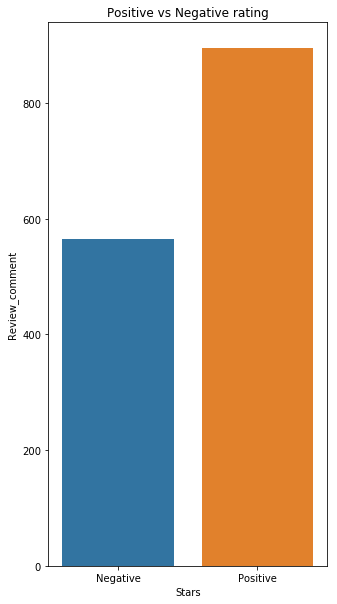

In [13]:
# Plot the graph for number of Positive and Negative stars for Bar.csv
plt.subplots(figsize=(5,10))
sns.barplot(x='Stars', y = 'Review_comment', data=data_df).set_title("Positive vs Negative rating")

In [14]:
# To check how many Stars are Positive and Negative, get the count of them
data_df = restaurant_txt.groupby("Stars").count().reset_index()

In [15]:
data_df

,Stars,Review_comment
0,Negative,507
1,Positive,933


Text(0.5, 1.0, 'Positive vs Negative rating')

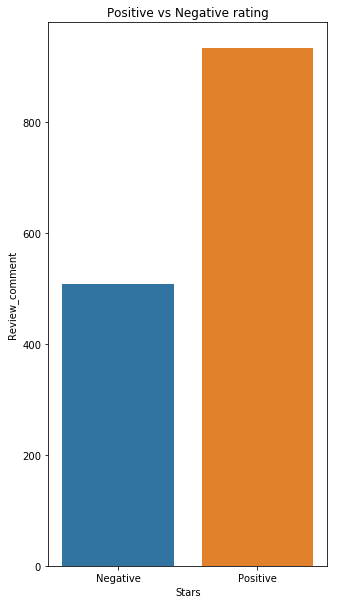

In [16]:
plt.subplots(figsize=(5,10))
sns.barplot(x='Stars', y = 'Review_comment', data=data_df).set_title("Positive vs Negative rating")

### Method to carry out the data pre-processing step

In [17]:
# Method where the review_comment column is fetched and the stop words are removed ,
# the code is stemmed and lemmetazed
def text_pre_processing(msg):
    # Stopwords list 
    stop = stopwords.words('english') + list(string.punctuation)
    tokenizedRandomData = msg.lower().split()
    # then use NLTK to perform lemmatisation on each token
    lemmatizer = nltk.stem.WordNetLemmatizer()
    lemma_tokens = []
    for token in tokenizedRandomData:
        if token not in stop:
            lemma_tokens.append( lemmatizer.lemmatize(token) )
    
    new_sentence = ' '.join(lemma_tokens)
    return new_sentence

In [18]:
# Calling the text_pre_processing method on the review_comment column
restaurant_txt['Review_comment'] = restaurant_txt['Review_comment'].apply(text_pre_processing)

# display the content after pre-processing
restaurant_txt.head()

,Review_comment,Stars
0,expensive had... egg benedict plate called la ...,Negative
1,"rustic place. mismatched furniture, knick knac...",Positive
2,highly recommend au festin de babette brunch. ...,Positive
3,amazing soup dauphinoise. wait table wait food...,Negative
4,went recommendation friend. though food enjoya...,Negative


In [19]:
# Calling the text_pre_processing method on the review_comment column
bar_txt['Review_comment'] = bar_txt['Review_comment'].apply(text_pre_processing)

# display the content after pre-processing
bar_txt.head()

,Review_comment,Stars
0,would help front girl sit u ask u drink put u ...,Negative
1,one star that's least amount leave. understand...,Negative
2,"bad time today. dirty windows, table sticky, h...",Negative
3,second visit last year. experience similar: aw...,Negative
4,"absolutely awful! took forever get food, food ...",Negative


# Classifiers

Machine learning works on the concept of diving data into training and test set , the trainings et is then used to train a model and the test set is used to evaluate the performance of a model. But best suited to estimate of out-of-sample accuracy.

### Converting the textual information into vectorixed values and generating accuracy with appropriate classifier

***Model evaluation metric:***
    1. Classification Accuracy 
    2. Accuracy calculated with confusion metric
    3. Misclassification rate
    4. Sensitivity
    5. Specificity

### The method used to train the model which has the fit and the predict method and also compute accuracy

In [20]:
def classifier(dataframe):
    
    # Splitting the data to train and test by using the dataframe that is passed to the function
    X_train, X_test, y_train, y_test = train_test_split(dataframe['Review_comment'], dataframe['Stars'])
    
    # Vectorize the textual value to numeric values
    tfidf_vect = TfidfVectorizer(min_df=5, stop_words=stopwords.words('english')) 
    
    # Use each category dataset and split them into train and test set
    tfidf_vect.fit(dataframe['Review_comment'])
    xtrain_tfidf =  tfidf_vect.transform(X_train)
    xtest_tfidf =  tfidf_vect.transform(X_test)

    # Creating a list with all teh classifiers that we are using
    classifiers = [
        KNeighborsClassifier(n_neighbors=5),
        MultinomialNB(),
        DecisionTreeClassifier(),
        RandomForestClassifier(),
        LogisticRegression(),
    ]

    # loop over the classifiers and fit the model and predict it along with generating the confusion matrix
    acc = []
    acc_cross_val = []
    for classifier in classifiers:
        # Creating a pipeline with which we can have multiple classifiers
        pipe = Pipeline(steps=[('classifier', classifier)])
        pipe.fit(xtrain_tfidf, y_train)  
        predicted = pipe.predict(xtest_tfidf)
        print("********************************CLASSIFICATION MODEL**************************************************")
        print(classifier)
        
        print("Accuracy score: %.3f" % accuracy_score(predicted, y_test))
        
        accuracy = cross_val_score(classifier, xtrain_tfidf, y_train, scoring='accuracy', cv=5)
        print("Accuracy for cross validation : " + str(round(100*accuracy.mean(), 2)))
        
        print("Classfication Report")
        print("______________________")
        print(metrics.classification_report(y_test, predicted))
        
        # save confusion matrix and slice into four pieces
        confusion = metrics.confusion_matrix(y_test, predicted)
        #[row, column]
        TP = confusion[1, 1]
        TN = confusion[0, 0]
        FP = confusion[0, 1]
        FN = confusion[1, 0]
        
        classification_error = (FP + FN) / float(TP + TN + FP + FN)
        sensitivity = TP / float(FN + TP)
        specificity = TN / (TN + FP)
        print("Accuracy computed by confusion matrix : " + str((TP + TN) / float(TP + TN + FP + FN)))
        print("Misclassification Rate : " + str(classification_error))
        print("Sensitivity : " + str(sensitivity))
        print("Specificity : " + str(specificity))
        
        print("Confusion Metrics")
        print("__________________")
        print(pd.crosstab(np.array(y_test), predicted, rownames=['True'], colnames=['Predicted'], margins=True))
        
        # appending the accuracy scores to a list which is later used for plotting purpose
        acc.append(accuracy_score(predicted, y_test)*100)
        acc_cross_val.append(100*accuracy.mean())
        
    return acc, acc_cross_val

***Calling the classifier method on the Restaurant data***

In [21]:
accuracies_restaurant,accuracies_restaurant_cross_val  = classifier(restaurant_txt)

********************************CLASSIFICATION MODEL**************************************************
KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=5, p=2,
           weights='uniform')
Accuracy score: 0.756
Accuracy for cross validation : 77.23
Classfication Report
______________________
              precision    recall  f1-score   support

    Negative       0.76      0.51      0.61       136
    Positive       0.75      0.90      0.82       224

   micro avg       0.76      0.76      0.76       360
   macro avg       0.76      0.71      0.72       360
weighted avg       0.76      0.76      0.74       360

Accuracy computed by confusion matrix : 0.7555555555555555
Misclassification Rate : 0.24444444444444444
Sensitivity : 0.9017857142857143
Specificity : 0.5147058823529411
Confusion Metrics
__________________
Predicted  Negative  Positive  All
True                              
Negative         70   

C:\Users\Chaitra\Anaconda3\envs\Python\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Accuracy for cross validation : 75.74
Classfication Report
______________________
              precision    recall  f1-score   support

    Negative       0.72      0.65      0.68       136
    Positive       0.80      0.84      0.82       224

   micro avg       0.77      0.77      0.77       360
   macro avg       0.76      0.75      0.75       360
weighted avg       0.77      0.77      0.77       360

Accuracy computed by confusion matrix : 0.7694444444444445
Misclassification Rate : 0.23055555555555557
Sensitivity : 0.84375
Specificity : 0.6470588235294118
Confusion Metrics
__________________
Predicted  Negative  Positive  All
True                              
Negative         88        48  136
Positive         35       189  224
All             123       237  360
********************************CLASSIFICATION MODEL**************************************************
LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=

C:\Users\Chaitra\Anaconda3\envs\Python\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Chaitra\Anaconda3\envs\Python\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


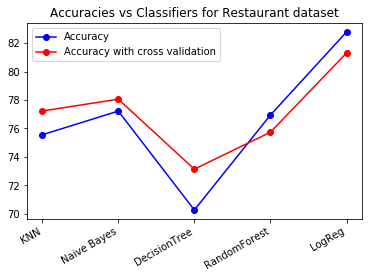

In [22]:
x = ['KNN', 'Naive Bayes', 'DecisionTree', 'RandomForest', 'LogReg']

f, ax = plt.subplots(1, 1)
ax.plot_date(x, accuracies_restaurant, color="blue", label="Accuracy", linestyle="-")
ax.plot_date(x, accuracies_restaurant_cross_val, color="red", label="Accuracy with cross validation", linestyle="-")
ax.legend()

plt.title("Accuracies vs Classifiers for Restaurant dataset")
plt.gcf().autofmt_xdate()
plt.show()


In the above graph we can see that the ***Blue Line*** indicates the value accuarcy generated by the models and the ***Red line*** fine in the graph indicates the accuracy after running cross_validation on these classifiers

***Calling the classifier method on the Bar data***

In [23]:
accuracies_bar, accuracies_bar_cross_val = classifier(bar_txt)

********************************CLASSIFICATION MODEL**************************************************
KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=5, p=2,
           weights='uniform')
Accuracy score: 0.792
Accuracy for cross validation : 76.71
Classfication Report
______________________
              precision    recall  f1-score   support

    Negative       0.79      0.66      0.72       146
    Positive       0.79      0.88      0.84       219

   micro avg       0.79      0.79      0.79       365
   macro avg       0.79      0.77      0.78       365
weighted avg       0.79      0.79      0.79       365

Accuracy computed by confusion matrix : 0.7917808219178082
Misclassification Rate : 0.20821917808219179
Sensitivity : 0.8812785388127854
Specificity : 0.6575342465753424
Confusion Metrics
__________________
Predicted  Negative  Positive  All
True                              
Negative         96   

C:\Users\Chaitra\Anaconda3\envs\Python\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


              precision    recall  f1-score   support

    Negative       0.76      0.68      0.72       146
    Positive       0.80      0.86      0.83       219

   micro avg       0.79      0.79      0.79       365
   macro avg       0.78      0.77      0.77       365
weighted avg       0.78      0.79      0.78       365

Accuracy computed by confusion matrix : 0.7863013698630137
Misclassification Rate : 0.2136986301369863
Sensitivity : 0.8584474885844748
Specificity : 0.678082191780822
Confusion Metrics
__________________
Predicted  Negative  Positive  All
True                              
Negative         99        47  146
Positive         31       188  219
All             130       235  365
********************************CLASSIFICATION MODEL**************************************************
LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_stat

C:\Users\Chaitra\Anaconda3\envs\Python\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Chaitra\Anaconda3\envs\Python\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


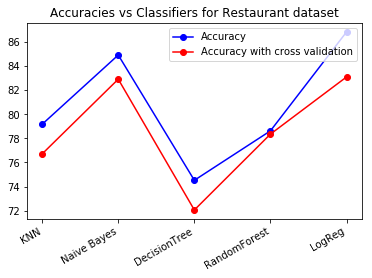

In [24]:
f, ax = plt.subplots(1, 1)
ax.plot_date(x, accuracies_bar, color="blue", label="Accuracy", linestyle="-")
ax.plot_date(x, accuracies_bar_cross_val, color="red", label="Accuracy with cross validation", linestyle="-")
ax.legend()

plt.title("Accuracies vs Classifiers for Restaurant dataset")
plt.gcf().autofmt_xdate()
plt.show()


In the above graoh we ca see that the ***Blue Line*** indicates the value accuarcy generated by the models and the ***Red line*** fine in the graoh indicates the accuracy after running cross_validation on these classifiers

***Cross Validation:*** In case of cross validation it might lead to variance issue , the accuracy obtained by one test set is quite different from the one obtained by another with the same algorithm.
    

***Observation:***  In our case the data was textual and hence we used the TfIDF vectorizor to convert it into numeric values. Using 4 different models to train and test each of the catergories chosen (here i have chosen the Restaurent and the Bar dataset) , and computed the accuracy results for these two caterogies. 
There are lot of factors that we can used to measure the performance of a model
1. *Classfictaion Accuracy :* Which is computed by using the train set to train the model and test set to test the model
2. *Accuracy:* computed using the confusion metrics: We also can generate a confusion metrics which would suggest how often the classfier was correct .
3. *classficiation error/ Misclassification rate:* this is used to estimate how often the classifier is incorrect.
4. *Sensitivity :* when the value of this is positive how often the prediction is correct, how often will the classifier provide the accurate results. How sensitive is the classifier in predicting the positive results.
5. *Specificity:* How specific is our classifier in predicting positive instance.

For both the catergories , we have seen that the ***MultinomialNB*** and ***LogisticRegression*** regression performed the best. 

***Naive Bayes*** => based on Bayes’ Theorem with an assumption of independence among predictors. A Naive Bayes classifier assumes that the presence of a particular feature in a class is unrelated to the presence of any other feature.

***Logistic regression*** => measures the relationship between the categorical dependent variable and one or more independent variables by estimating probabilities using a logistic/sigmoid function. 

Also as seen in the results , there is less misclassification rate and higher accuracy for for these two models.

### Hypothesis: Since both Bar and Restaurant belong to almost similar category, we can state that the accuracy will be higher for these comparision

### Common method to classify between categories

In [25]:
def classfier_between_categories(dataframe1, dataframe2):
    # Use the TfidfVectorizer to convert tectual value into numeric
    tfidfconverter = TfidfVectorizer(min_df=5, stop_words=stopwords.words('english')) 
    
    # The review_comment will be our X and we use the TfidfVectorizer fit_tranform
    train_X = tfidfconverter.fit_transform(dataframe1['Review_comment']).toarray() 
    test_X = tfidfconverter.transform(dataframe2['Review_comment']).toarray()
    
    train_y = dataframe1['Stars']
    test_y = dataframe2['Stars']
    
    # Creating a list with all teh classifiers that we are using
    classifiers = [
        KNeighborsClassifier(n_neighbors=5),
        MultinomialNB(),
        DecisionTreeClassifier(),
        RandomForestClassifier(),
        LogisticRegression(),
    ]
    
    accuracy_list = []
    acc_cross_val = []
    # loop over the classifiers and fit the model and predict it along with generating the confusion matrix
    for classifier in classifiers:
         # Creating a pipeline with which we can have multiple classifiers
        pipe = Pipeline(steps=[('classifier', classifier)])
        pipe.fit(train_X, train_y)   
        predicted = pipe.predict(test_X)
        
        print("********************************CLASSIFICATION MODEL**************************************************")
        print(classifier)
        
        print("Accuracy score: %.3f" % accuracy_score(predicted, test_y))
        
        accuracy = cross_val_score(classifier, train_X, train_y, scoring='accuracy', cv=5)
        print("Accuracy for cross validation : " + str(round(100*accuracy.mean(), 2)))
        
        print("Classfication Report")
        print("________________________")
        print(metrics.classification_report(test_y, predicted))
        
        # save confusion matrix and slice into four pieces
        confusion = metrics.confusion_matrix(test_y, predicted)
        # Taking the values from the confusion metrics
        #[row, column]
        TP = confusion[1, 1]
        TN = confusion[0, 0]
        FP = confusion[0, 1]
        FN = confusion[1, 0]
        
        # computing the scores for different metrics
        classification_error = (FP + FN) / float(TP + TN + FP + FN)
        sensitivity = TP / float(FN + TP)
        specificity = TN / (TN + FP)
        print("Metrics computed by confusion matrix : " + str((TP + TN) / float(TP + TN + FP + FN)))
        print("Misclassification Rate : " +str(classification_error))
        print("Sensitivity : " + str(sensitivity))
        print("Specificity : " + str(specificity))
        print("Confusion Metrics")
        print("________________________")
        print(pd.crosstab(np.array(test_y), predicted, rownames=['True'], colnames=['Predicted'], margins=True))
        accuracy_list.append(accuracy_score(predicted, test_y)*100)
        acc_cross_val.append(100*accuracy.mean())
    return accuracy_list, acc_cross_val

# Category A (Restaurant) as training and Category B(Bar) as test

In [26]:
accuracy_Res_bar, accuracy_Res_bar_cross_val = classfier_between_categories(restaurant_txt, bar_txt)

********************************CLASSIFICATION MODEL**************************************************
KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=5, p=2,
           weights='uniform')
Accuracy score: 0.760
Accuracy for cross validation : 74.65
Classfication Report
________________________
              precision    recall  f1-score   support

    Negative       0.73      0.60      0.66       565
    Positive       0.77      0.86      0.82       895

   micro avg       0.76      0.76      0.76      1460
   macro avg       0.75      0.73      0.74      1460
weighted avg       0.76      0.76      0.75      1460

Metrics computed by confusion matrix : 0.7602739726027398
Misclassification Rate : 0.23972602739726026
Sensitivity : 0.8614525139664805
Specificity : 0.6
Confusion Metrics
________________________
Predicted  Negative  Positive   All
True                               
Negative        339       22

C:\Users\Chaitra\Anaconda3\envs\Python\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Accuracy for cross validation : 79.1
Classfication Report
________________________
              precision    recall  f1-score   support

    Negative       0.75      0.70      0.72       565
    Positive       0.82      0.85      0.83       895

   micro avg       0.79      0.79      0.79      1460
   macro avg       0.78      0.78      0.78      1460
weighted avg       0.79      0.79      0.79      1460

Metrics computed by confusion matrix : 0.7924657534246575
Misclassification Rate : 0.20753424657534247
Sensitivity : 0.8480446927374302
Specificity : 0.7044247787610619
Confusion Metrics
________________________
Predicted  Negative  Positive   All
True                               
Negative        398       167   565
Positive        136       759   895
All             534       926  1460
********************************CLASSIFICATION MODEL**************************************************
LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercep

C:\Users\Chaitra\Anaconda3\envs\Python\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Chaitra\Anaconda3\envs\Python\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Chaitra\Anaconda3\envs\Python\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Chaitra\Anaconda3\envs\Python\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Chaitra\Anaconda3\envs\Python\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default so

              precision    recall  f1-score   support

    Negative       0.90      0.68      0.77       565
    Positive       0.82      0.95      0.88       895

   micro avg       0.85      0.85      0.85      1460
   macro avg       0.86      0.82      0.83      1460
weighted avg       0.85      0.85      0.84      1460

Metrics computed by confusion matrix : 0.8465753424657534
Misclassification Rate : 0.15342465753424658
Sensitivity : 0.9541899441340782
Specificity : 0.6761061946902654
Confusion Metrics
________________________
Predicted  Negative  Positive   All
True                               
Negative        382       183   565
Positive         41       854   895
All             423      1037  1460


# Category B(Bar) as training and Category A(Restaurant) as test

In [27]:
accuracy_Bar_Res, accuracy_bar_Res_cross_val = classfier_between_categories(bar_txt, restaurant_txt)

********************************CLASSIFICATION MODEL**************************************************
KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=5, p=2,
           weights='uniform')
Accuracy score: 0.765
Accuracy for cross validation : 73.01
Classfication Report
________________________
              precision    recall  f1-score   support

    Negative       0.68      0.64      0.66       507
    Positive       0.81      0.83      0.82       933

   micro avg       0.76      0.76      0.76      1440
   macro avg       0.74      0.74      0.74      1440
weighted avg       0.76      0.76      0.76      1440

Metrics computed by confusion matrix : 0.7645833333333333
Misclassification Rate : 0.23541666666666666
Sensitivity : 0.8338692390139335
Specificity : 0.6370808678500987
Confusion Metrics
________________________
Predicted  Negative  Positive   All
True                               
Negative     

C:\Users\Chaitra\Anaconda3\envs\Python\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Accuracy for cross validation : 78.9
Classfication Report
________________________
              precision    recall  f1-score   support

    Negative       0.64      0.70      0.67       507
    Positive       0.83      0.79      0.81       933

   micro avg       0.76      0.76      0.76      1440
   macro avg       0.74      0.74      0.74      1440
weighted avg       0.76      0.76      0.76      1440

Metrics computed by confusion matrix : 0.7569444444444444
Misclassification Rate : 0.24305555555555555
Sensitivity : 0.789924973204716
Specificity : 0.6962524654832347
Confusion Metrics
________________________
Predicted  Negative  Positive   All
True                               
Negative        353       154   507
Positive        196       737   933
All             549       891  1440
********************************CLASSIFICATION MODEL**************************************************
LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept

C:\Users\Chaitra\Anaconda3\envs\Python\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Chaitra\Anaconda3\envs\Python\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Chaitra\Anaconda3\envs\Python\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Chaitra\Anaconda3\envs\Python\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Chaitra\Anaconda3\envs\Python\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default so

Accuracy for cross validation : 83.77
Classfication Report
________________________
              precision    recall  f1-score   support

    Negative       0.86      0.72      0.78       507
    Positive       0.86      0.93      0.90       933

   micro avg       0.86      0.86      0.86      1440
   macro avg       0.86      0.83      0.84      1440
weighted avg       0.86      0.86      0.86      1440

Metrics computed by confusion matrix : 0.8590277777777777
Misclassification Rate : 0.14097222222222222
Sensitivity : 0.9346195069667739
Specificity : 0.7199211045364892
Confusion Metrics
________________________
Predicted  Negative  Positive   All
True                               
Negative        365       142   507
Positive         61       872   933
All             426      1014  1440


### Plot the graphs for these categories

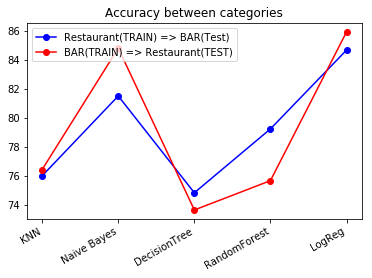

In [28]:
f, ax = plt.subplots(1, 1)
ax.plot_date(x, accuracy_Res_bar, color="blue", label="Restaurant(TRAIN) => BAR(Test)", linestyle="-")
ax.plot_date(x, accuracy_Bar_Res, color="red", label="BAR(TRAIN) => Restaurant(TEST)", linestyle="-")
ax.legend()

plt.title("Accuracy between categories")
plt.gcf().autofmt_xdate()
plt.show()

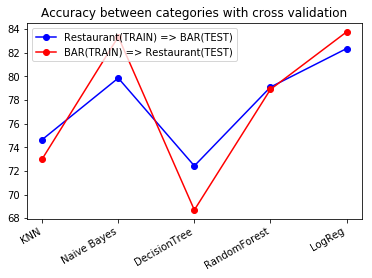

In [30]:
f, ax = plt.subplots(1, 1)
ax.plot_date(x, accuracy_Res_bar_cross_val, color="blue", label="Restaurant(TRAIN) => BAR(TEST)", linestyle="-")
ax.plot_date(x, accuracy_bar_Res_cross_val, color="red", label="BAR(TRAIN) => Restaurant(TEST)", linestyle="-")
ax.legend()

plt.title("Accuracy between categories with cross validation")
plt.gcf().autofmt_xdate()
plt.show()

### ALL combined graph

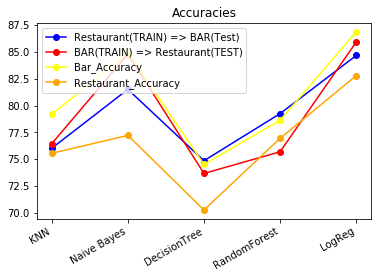

In [29]:
f, ax = plt.subplots(1, 1)
ax.plot_date(x, accuracy_Res_bar, color="blue", label="Restaurant(TRAIN) => BAR(Test)", linestyle="-")
ax.plot_date(x, accuracy_Bar_Res, color="red", label="BAR(TRAIN) => Restaurant(TEST)", linestyle="-")
ax.plot_date(x, accuracies_bar, color="yellow", label="Bar_Accuracy", linestyle="-")
ax.plot_date(x, accuracies_restaurant, color="orange", label="Restaurant_Accuracy", linestyle="-")
ax.legend()

plt.title("Accuracies")
plt.gcf().autofmt_xdate()
plt.show()

***Observation*** : If you observe the comparision between all the categories. BAR alone, Restaurant alone, Bar(Train) & Restaurant(Test) and viceversa.
    We could see that the Bar Dataset has performed best and second best is the combination of bar as TRain and Restaurant as test .
    Hence we can easily state it would be easier to make recommendation for a restaurant based on the bar review comments.

***Observation:*** By using *RESTAURANT* review as training set , and testing the accuracy of the *BAR* reviews by using as test set and viceversa. We could see that both of these categories are interrealted, and it is clearly seen in the accuracy scores that is computed . So we will be able to made predictions for a good restaurant by training the model on the review of a Bar and the other way is also true. Even in this case we could clearly see that the MultinomialNB naive bayes and the LogisticRegression.
Based on the accuracy and the misclassification values it is clear that by training the model on teh bar review_comment and predicting the restaurant performed much better and hence it is a good option to recommend a restaurant based on the review from the bar .

***Logistic regression:*** The model performs well for our data because we have binary classification (Positive/Negative) for labels. This works well for correlated with each other.

***Hypothesis Proved:*** The Hypothesis is proven and we can observe that the accuracy for the model comparision is good and hence we can tell both of these categories are interrelated.

***Conclusion:***
Overall by training the data from two different categories ***Bar*** and ***Restaurant*** , the classfiers chosen were Knn, NaiveBayes, Decision trees , Random forest and Logistic regression.
The results clearly indicate that two of the algorithms MultinomialNB naive bayes and the LogisticRegression performed best than the others, also random forest has performed considerable well than these two models. With the data chosen it would be easier to make recommendation for a ***RESTAURANT*** by using the review comment from a ***BAR*** and similarly using the review comment from the ***BAR*** can be used to suggest a ***RESTAURANT***.
This data is related and hence we could see higher accuracy when one of them was trained on a model and the testing was done on another.
These models also have lesser misclassfictaion rate. The metrics like confusion metrics, precision , recall gives better understanding 
on how each of teh classfiers have performed.
The graphs plotted gives a clear picture of the accuracies for these chosen categories.
